#### Library

In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
import torchvision.transforms as T 
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn 
import matplotlib.pyplot as plt
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score 

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

#### Data Load

In [3]:
# Tensor 형태로 변환
mnist_transform = T.Compose([T.ToTensor()])# 이미지를 정규화하고 C, H, W 형식으로 바꿈
download_root = "../data/MNIST_DATASET" # 경로 지정

train_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True)

In [4]:
for image, label in train_dataset:
    print(image.shape, label) # 여기서 image의 shape은 [C, H, W]로 구성
    break

torch.Size([1, 28, 28]) 5


In [5]:
# train/val 분리
total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print(f"Train dataset: {train_num}")
print(f"Validation dataset: {valid_num}")
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset: 48000
Validation dataset: 12000


In [6]:
batch_size = 32

# DataLoader 선언
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

for images, labels in train_dataloader:
  print(images.shape, labels.shape)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])


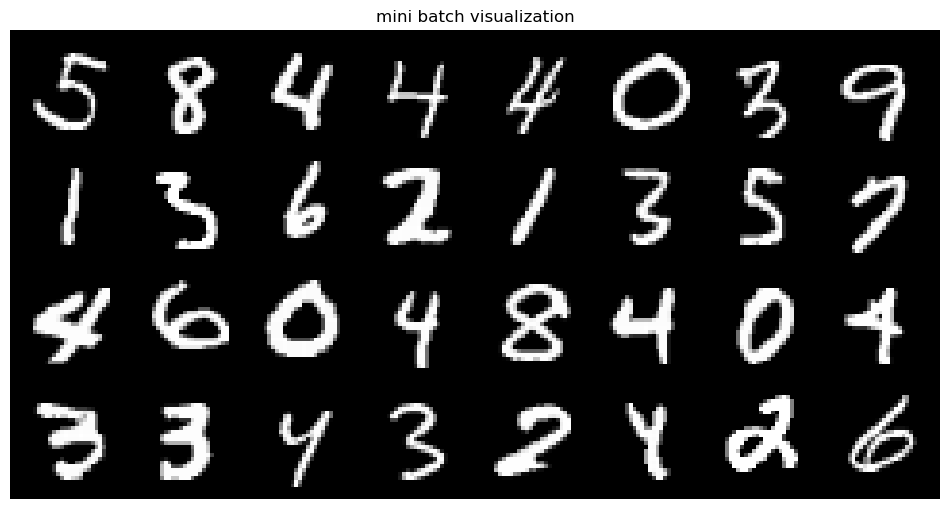

In [7]:
grid = vutils.make_grid(images, nrow=8) # 각 행마다 8개의 이미지 배치하여 격자로 구성

# 시각화
plt.figure(figsize=(12,12))
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.title("mini batch visualization")
plt.axis('off')
plt.show()

#### Model

In [8]:
class DNN(nn.Module):
  def __init__(self, hidden_dims, num_classes, dropout_ratio, apply_batchnorm, apply_dropout, apply_activation, set_super):
    if set_super:
      super().__init__()

    self.hidden_dims = hidden_dims
    self.layers = nn.ModuleList()

    for i in range(len(self.hidden_dims) - 1):
      self.layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i+1]))

      if apply_batchnorm:
        self.layers.append(nn.BatchNorm1d(self.hidden_dims[i+1]))

      if apply_activation:
        self.layers.append(nn.ReLU())

      if apply_dropout:
        self.layers.append(nn.Dropout(dropout_ratio))

    self.classifier = nn.Linear(self.hidden_dims[-1], num_classes)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, x):
    """
    Input and Output Summary

    Input:
      x: [batch_size, 1, 28, 28]
    Output:
      output: [batch_size, num_classes]

    """
    x = x.view(x.shape[0], -1)  # [batch_size, 784]

    for layer in self.layers:
      x = layer(x)

    x = self.classifier(x) # [batch_size, 10]
    output = self.softmax(x) # [batch_size, 10]
    return output

In [9]:
hidden_dim = 128
hidden_dims = [784, hidden_dim * 4, hidden_dim * 2, hidden_dim]
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
output = model(torch.randn((32, 1, 28, 28)))

#### Weight Initialization

In [10]:
# 가중치 초기화
def weight_initialization(model, weight_init_method):
  for m in model.modules():
    if isinstance(m, nn.Linear):
      if weight_init_method == 'gaussian':
        nn.init.normal_(m.weight)
      elif weight_init_method == 'xavier':
        nn.init.xavier_normal_(m.weight)
      elif weight_init_method == 'kaiming':
        nn.init.kaiming_normal_(m.weight)
      elif weight_init_method == 'zeros':
        nn.init.zeros_(m.weight)

      nn.init.zeros_(m.bias)

  return model

In [11]:
init_method = 'zeros' # gaussian, xavier, kaiming, zeros
model = weight_initialization(model, init_method)

for m in model.modules():
  if isinstance(m, nn.Linear):
    print(m.weight.data)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


#### Final Model

In [12]:
# 최종 모델 코드
class DNN(nn.Module):
  def __init__(self, hidden_dims, num_classes, dropout_ratio, apply_batchnorm, apply_dropout, apply_activation, set_super):
    if set_super:
      super().__init__()

    self.hidden_dims = hidden_dims
    self.layers = nn.ModuleList()

    for i in range(len(self.hidden_dims) - 1):
      self.layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i+1]))

      if apply_batchnorm:
        self.layers.append(nn.BatchNorm1d(self.hidden_dims[i+1]))

      if apply_activation:
        self.layers.append(nn.ReLU())

      if apply_dropout:
        self.layers.append(nn.Dropout(dropout_ratio))

    self.classifier = nn.Linear(self.hidden_dims[-1], num_classes)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, x):
    """
    Input and Output Summary

    Input:
      x: [batch_size, 1, 28, 28]
    Output:
      output: [batch_size, num_classes]

    """
    x = x.view(x.shape[0], -1)  # [batch_size, 784]

    for layer in self.layers:
      x = layer(x)

    x = self.classifier(x) # [batch_size, 10]
    output = self.softmax(x) # [batch_size, 10]
    return output

  def weight_initialization(self, weight_init_method):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        if weight_init_method == 'gaussian':
          nn.init.normal_(m.weight)
        elif weight_init_method == 'xavier':
          nn.init.xavier_normal_(m.weight)
        elif weight_init_method == 'kaiming':
          nn.init.kaiming_normal_(m.weight)
        elif weight_init_method == 'zeros':
          nn.init.zeros_(m.weight)

        nn.init.zeros_(m.bias)

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)  # numel()은 텐서의 원소 개수를 반환하는 함수

In [13]:
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
init_method = 'gaussian' # gaussian, xavier, kaiming, zeros
model.weight_initialization(init_method)
print(f'The model has {model.count_parameters():,} trainable parameters')

The model has 569,226 trainable parameters


#### Loss Function

In [14]:
criterion = nn.NLLLoss()

#### Optimizer

In [15]:
lr = 0.001
hidden_dim = 128
hidden_dims = [784, hidden_dim * 4, hidden_dim * 2, hidden_dim]
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
optimizer = optim.Adam(model.parameters(), lr = lr)

#### Train

In [16]:
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
  model.train()  # 모델을 학습 모드로 설정
  train_loss = 0.0
  train_accuracy = 0

  tbar = tqdm(dataloader)
  for images, labels in tbar:
      images = images.to(device)
      labels = labels.to(device)

      # 순전파
      outputs = model(images)
      loss = criterion(outputs, labels)

      # 역전파 및 weights 업데이트
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 손실과 정확도 계산
      train_loss += loss.item()
      # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
      _, predicted = torch.max(outputs, 1)
      train_accuracy += (predicted == labels).sum().item()

      # tqdm의 진행바에 표시될 설명 텍스트를 설정
      tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

  # 에폭별 학습 결과 출력
  train_loss = train_loss / len(dataloader)
  train_accuracy = train_accuracy / len(train_dataset)

  return model, train_loss, train_accuracy

def evaluation(model, dataloader, valid_dataset, criterion, device, epoch, num_epochs):
  model.eval()  # 모델을 평가 모드로 설정
  valid_loss = 0.0
  valid_accuracy = 0

  with torch.no_grad(): # model의 업데이트 막기
      tbar = tqdm(dataloader)
      for images, labels in tbar:
          images = images.to(device)
          labels = labels.to(device)

          # 순전파
          outputs = model(images)
          loss = criterion(outputs, labels)

          # 손실과 정확도 계산
          valid_loss += loss.item()
          # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
          _, predicted = torch.max(outputs, 1)
          valid_accuracy += (predicted == labels).sum().item()

          # tqdm의 진행바에 표시될 설명 텍스트를 설정
          tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")

  valid_loss = valid_loss / len(dataloader)
  valid_accuracy = valid_accuracy / len(valid_dataset)

  return model, valid_loss, valid_accuracy


def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
          valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return model, valid_max_accuracy

In [17]:
num_epochs = 100
patience = 3
scores = dict()
device = 'cpu' # cpu 설정 (Mac Loacal 진행)
model_name = 'exp1'
init_method = 'kaiming' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.3178, Train Accuracy: 0.9046 Valid Loss: 0.1260, Valid Accuracy: 0.9615


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.1622, Train Accuracy: 0.9505 Valid Loss: 0.1015, Valid Accuracy: 0.9678


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.1314, Train Accuracy: 0.9590 Valid Loss: 0.0897, Valid Accuracy: 0.9729


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.1116, Train Accuracy: 0.9646 Valid Loss: 0.0775, Valid Accuracy: 0.9753


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.0981, Train Accuracy: 0.9687 Valid Loss: 0.0673, Valid Accuracy: 0.9797


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.0857, Train Accuracy: 0.9730 Valid Loss: 0.0696, Valid Accuracy: 0.9787


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.0772, Train Accuracy: 0.9754 Valid Loss: 0.0697, Valid Accuracy: 0.9784


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0674, Train Accuracy: 0.9785 Valid Loss: 0.0634, Valid Accuracy: 0.9823


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.0609, Train Accuracy: 0.9801 Valid Loss: 0.0631, Valid Accuracy: 0.9809


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.0586, Train Accuracy: 0.9815 Valid Loss: 0.0669, Valid Accuracy: 0.9803


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.0544, Train Accuracy: 0.9821 Valid Loss: 0.0630, Valid Accuracy: 0.9831


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.0554, Train Accuracy: 0.9821 Valid Loss: 0.0662, Valid Accuracy: 0.9807


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.0461, Train Accuracy: 0.9846 Valid Loss: 0.0597, Valid Accuracy: 0.9825


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.0431, Train Accuracy: 0.9865 Valid Loss: 0.0610, Valid Accuracy: 0.9823


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.0442, Train Accuracy: 0.9854 Valid Loss: 0.0617, Valid Accuracy: 0.9816


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.0393, Train Accuracy: 0.9869 Valid Loss: 0.0616, Valid Accuracy: 0.9828
Early stopping


#### Batch normalization 제외

In [18]:
# Batch normalization을 제외하고 학습 진행
model_name = 'exp2'
init_method = 'kaiming' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = False, apply_dropout = True, apply_activation = True, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.2839, Train Accuracy: 0.9134 Valid Loss: 0.1365, Valid Accuracy: 0.9599


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.1316, Train Accuracy: 0.9611 Valid Loss: 0.1105, Valid Accuracy: 0.9678


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.1022, Train Accuracy: 0.9704 Valid Loss: 0.0892, Valid Accuracy: 0.9738


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.0855, Train Accuracy: 0.9745 Valid Loss: 0.1010, Valid Accuracy: 0.9711


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.0743, Train Accuracy: 0.9772 Valid Loss: 0.0817, Valid Accuracy: 0.9782


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.0636, Train Accuracy: 0.9808 Valid Loss: 0.0889, Valid Accuracy: 0.9778


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.0575, Train Accuracy: 0.9824 Valid Loss: 0.0840, Valid Accuracy: 0.9780


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0523, Train Accuracy: 0.9838 Valid Loss: 0.0817, Valid Accuracy: 0.9785


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.0465, Train Accuracy: 0.9863 Valid Loss: 0.0806, Valid Accuracy: 0.9801


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.0450, Train Accuracy: 0.9868 Valid Loss: 0.0900, Valid Accuracy: 0.9786


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.0421, Train Accuracy: 0.9875 Valid Loss: 0.0995, Valid Accuracy: 0.9778


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.0393, Train Accuracy: 0.9883 Valid Loss: 0.0861, Valid Accuracy: 0.9792
Early stopping


#### Dropout을 제외

In [19]:
# Dropout을 제외하고 학습 진행
model_name = 'exp3'
init_method = 'kaiming' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = False, apply_activation = True, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.2168, Train Accuracy: 0.9348 Valid Loss: 0.1049, Valid Accuracy: 0.9667


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.1039, Train Accuracy: 0.9671 Valid Loss: 0.0888, Valid Accuracy: 0.9737


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.0786, Train Accuracy: 0.9747 Valid Loss: 0.0842, Valid Accuracy: 0.9748


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.0646, Train Accuracy: 0.9802 Valid Loss: 0.0718, Valid Accuracy: 0.9777


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.0522, Train Accuracy: 0.9828 Valid Loss: 0.0698, Valid Accuracy: 0.9792


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.0422, Train Accuracy: 0.9864 Valid Loss: 0.0738, Valid Accuracy: 0.9783


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.0381, Train Accuracy: 0.9878 Valid Loss: 0.0729, Valid Accuracy: 0.9799


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0373, Train Accuracy: 0.9876 Valid Loss: 0.0803, Valid Accuracy: 0.9790
Early stopping


#### Activation Function 제외

In [20]:
# 활성화 함수(activation function)를 제외하고 학습을 진행합니다.
model_name = 'exp4'
init_method = 'kaiming' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = False, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.4584, Train Accuracy: 0.8641 Valid Loss: 0.3394, Valid Accuracy: 0.9050


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.3789, Train Accuracy: 0.8898 Valid Loss: 0.3528, Valid Accuracy: 0.8998


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.3584, Train Accuracy: 0.8947 Valid Loss: 0.3263, Valid Accuracy: 0.9114


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.3506, Train Accuracy: 0.8959 Valid Loss: 0.3134, Valid Accuracy: 0.9120


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.3430, Train Accuracy: 0.9010 Valid Loss: 0.3208, Valid Accuracy: 0.9101


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.3347, Train Accuracy: 0.9025 Valid Loss: 0.3184, Valid Accuracy: 0.9096


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.3344, Train Accuracy: 0.9024 Valid Loss: 0.3160, Valid Accuracy: 0.9113
Early stopping


#### Weight Initialization 0으로

In [21]:
model_name = 'exp5'
init_method = 'zeros' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.3017, Train Accuracy: 0.1118 Valid Loss: 2.3007, Valid Accuracy: 0.1133


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 2.3015, Train Accuracy: 0.1121 Valid Loss: 2.3007, Valid Accuracy: 0.1133


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 2.3015, Train Accuracy: 0.1121 Valid Loss: 2.3008, Valid Accuracy: 0.1133


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 2.3015, Train Accuracy: 0.1121 Valid Loss: 2.3008, Valid Accuracy: 0.1133


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 2.3015, Train Accuracy: 0.1121 Valid Loss: 2.3007, Valid Accuracy: 0.1133
Early stopping


#### Inference & Evaluation

In [ ]:
# BatchNorm, Dropout을 사용한 모델을 로드
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
model.load_state_dict(torch.load("..models/model_exp1.pt"))
model = model.to(device)

- Inference

In [23]:
model.eval()
total_labels = []
total_preds = []
total_probs = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels

        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        total_preds.extend(predicted.detach().cpu().tolist())
        total_labels.extend(labels.tolist())
        total_probs.append(outputs.detach().cpu().numpy())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
total_probs = np.concatenate(total_probs, axis= 0)

- Evaluation

In [24]:
# precision, recall, f1를 계산
precision = precision_score(total_labels, total_preds, average='macro')
recall = recall_score(total_labels, total_preds, average='macro')
f1 = f1_score(total_labels, total_preds, average='macro')

# AUC를 계산
# 모델의 출력으로 nn.LogSoftmax 함수가 적용되어 결과물이 출력
total_probs = np.exp(total_probs)
auc = roc_auc_score(total_labels, total_probs, average='macro', multi_class = 'ovr')
print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}, AUC: {auc}')

Precision: 0.9852826409260971, Recall: 0.9851242188042052, F1 Score: 0.985192726704814, AUC: 0.9997577614547168
